In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, RidgeCV
import matplotlib as mpl

from tqdm import tqdm


In [11]:
def generateData(nTrain,nTest,d,withLamb=True,wZero=False):
    XTrain = np.random.normal(size=(nTrain,d))
    XTest = np.random.normal(size=(nTest,d))
    
    if withLamb:
        lambsTrain = np.random.uniform(0,1,nTrain)
        lambsTest = np.random.uniform(0,1,nTest)
        XTrain = np.diag(lambsTrain)@XTrain
        XTest = np.diag(lambsTest)@XTest

    if wZero:
        w = np.zeros(d)
    else:
        w = np.random.normal(size=d)/(d**(1/2))
    
    YTrain = XTrain@w + np.random.normal(size=nTrain)
    YTest = XTest@w + np.random.normal(size=nTest)
    

    return XTrain, YTrain, XTest, YTest


In [12]:
### Estimate the training-conditional coverage of full conformal ridge with tau fixed and tau
### chosen using LOOCV on one draw of the training data.
def oneCVTrial(nTrain,nTest,d,alpha,taus=np.logspace(-4,1,50),tauFixed=0.1):
    XTrain, YTrain, XTest, YTest = generateData(nTrain,nTest,d)    
    
    ### run with cv
    cv_mod = RidgeCV(alphas = nTrain*taus, fit_intercept = False, scoring = 'neg_mean_squared_error')
    cv_mod.fit(XTrain,YTrain)
    covCV = 0
    for i in range(nTest):
        XFull = np.row_stack((XTrain,XTest[i,:]))
        YFull = np.append(YTrain,YTest[i])
        
        
        mod = Ridge(cv_mod.alpha_, fit_intercept=False)
        mod.fit(XFull,YFull)
        resid = np.abs(YFull - mod.predict(XFull))
        q = np.quantile(resid, 1-alpha)
        covCV = covCV + (resid[-1] <= q)/nTest

    
    ## run fixed tau 
    covFixed = 0
    for i in range(nTest):
        XFull = np.row_stack((XTrain,XTest[i,:]))
        YFull = np.append(YTrain,YTest[i])
        
        
        mod = Ridge(nTrain*tauFixed, fit_intercept=False)
        mod.fit(XFull,YFull)
        resid = np.abs(YFull - mod.predict(XFull))
        q = np.quantile(resid, 1-alpha)
        covFixed = covFixed + (resid[-1] <= q)/nTest
        
    return(covCV, covFixed, cv_mod.alpha_)


In [13]:
### Evaluate training-conditional coverage over many trials (draws of the training set)
nTest = 2000
nTrains = [100, 200, 400, 800]
ratio = 0.25
nTrials = 100
alpha = 0.1

res = pd.DataFrame()
for nTrain in nTrains:
    d = math.floor(ratio*nTrain)
    for i in tqdm(range(nTrials)):
        covCV, covFixed, tauCV = oneCVTrial(nTrain,nTest,d,alpha)
        newRes = pd.DataFrame({
            'Number of Training Points' : [nTrain, nTrain],
            'Dimension' : [d, d],
            'Method' : ['Regularization Chosen by LOOCV', 'Fixed Regularization'],
            'Coverage' : [covCV, covFixed],
            'tau' : [tauCV, 0]
        })
        res = pd.concat([res,newRes])
        

100%|█████████████████████████████████████████| 100/100 [26:41<00:00, 16.01s/it]


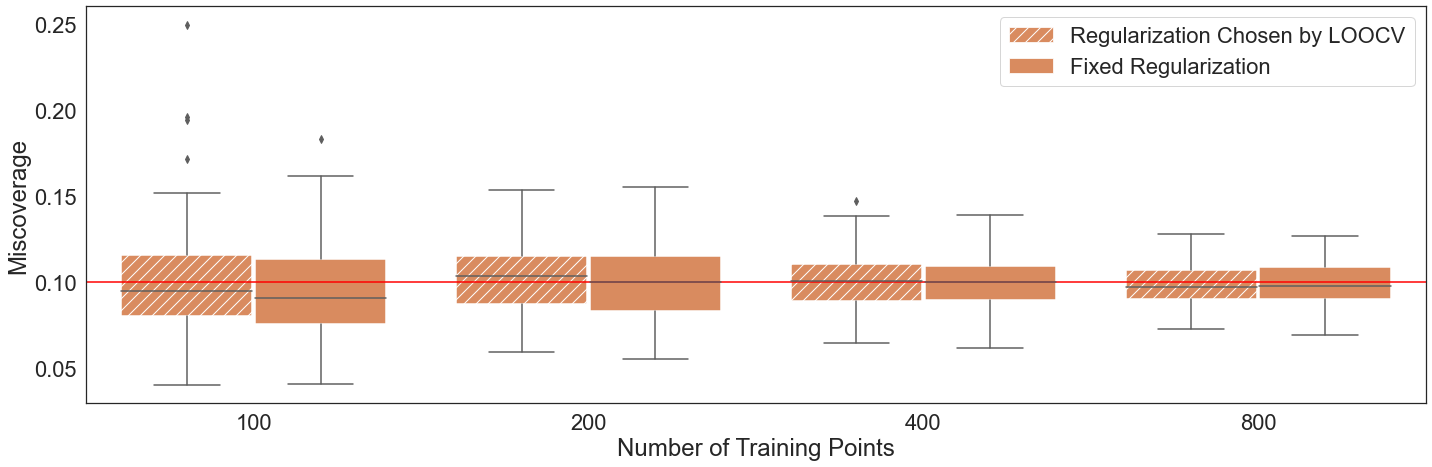

In [15]:
sns.set(rc={'figure.figsize':(24,7.3)})
sns.set(font_scale=2)
sns.set_style(style='white')
fig = plt.figure()

res['Miscoverage'] = 1 - res['Coverage']

cmap = {'Regularization Chosen by LOOCV' : sns.color_palette("muted")[:][1],
       'Fixed Regularization' : sns.color_palette("muted")[:][1]}


f1 = sns.boxplot(res,x='Number of Training Points',y='Miscoverage',hue='Method',palette=cmap)
f1.axhline(alpha, color='red')
plt.legend(loc='upper right')


### Add hatching following https://stackoverflow.com/questions/72656861/how-to-add-hatches-to-boxplots-with-sns-boxplot-or-sns-catplot
hatches = ['//', '']
patches = [patch for patch in f1.patches if type(patch) == mpl.patches.PathPatch]
# the number of patches should be evenly divisible by the number of hatches
h = hatches * (len(patches) // len(hatches))
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
    patch.set_edgecolor('w')
    
l = f1.legend()
    
for lp, hatch in zip(l.get_patches(), hatches):
    lp.set_hatch(hatch)
    lp.set_edgecolor('w')

plt.savefig('figures/CV_Validation.pdf')